<a href="https://colab.research.google.com/github/Nramyanaga/Pytorch-Learning/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [58]:
#Convert MNIST Image Files into a Tensor if 4-Dimensions(# of images, height width color channel)
transform = transforms.ToTensor()



In [59]:
# Train our data
train_data = datasets.MNIST(root='/cnn_data', train=True, download=True, transform=transform)

In [60]:
# Test our data
test_data = datasets.MNIST(root='/cnn_data', train=False, download=True, transform=transform)

In [61]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [62]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [63]:
pwd

'/content'

In [64]:
ls

sample_data/


In [65]:
cd ../cnn_data

/cnn_data


In [66]:
ls

MNIST/


In [67]:
cd ../

/


In [68]:
ls

bin@                        datalab/  lib32@   NGC-DL-CONTAINER-LICENSE  root/  tmp/
boot/                       dev/      lib64@   opt/                      run/   tools/
cnn_data/                   etc/      libx32@  proc/                     sbin@  usr/
content/                    home/     media/   python-apt/               srv/   var/
cuda-keyring_1.0-1_all.deb  lib@      mnt/     python-apt.tar.xz*        sys/


In [69]:
cd content/

/content


In [70]:
pwd

'/content'

In [71]:
# create a small batch size for images lets say 10
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)


In [72]:
# define our CNN model
# describe convulational layer and what its doing(2 convolutional layers)
# This is just an example.
conv1 =nn.Conv2d(1,6,3,1)
conv2 =nn.Conv2d(6,16,3,1)

In [73]:
# grab 1 mnist record/image
for(i, (X_train, y_train)) in enumerate(train_data):
  break

In [74]:
X_train.shape # 1 imahe 28x28 pixels

torch.Size([1, 28, 28])

In [75]:
x = X_train.view(1,1,28,28)


In [76]:
# Perform our 1st convultion
x = F.relu(conv1(x)) # rectify linear unit for our activation function


In [77]:
x.shape # convulation ran once and output this, 1 image
# i image, 6 filters, 26x26 is the image as the padding decreases the size as the outer pizels are dropped

torch.Size([1, 6, 26, 26])

In [78]:
# pass thru the pooling layer
x = F.max_pool2d(x,2,2) # the 2x2 will be kernel 2 and stride 2

In [79]:
# image 1 , 6 filters, pooling into 13x13 as 26/2
x.shape

torch.Size([1, 6, 13, 13])

In [80]:
# do our second convolutional layer
x = F.relu(conv2(x))

In [81]:
x.shape # loose from padding ass we didnt set its its 2 pixels

torch.Size([1, 16, 11, 11])

In [82]:
# pooling layer
x = F.max_pool2d(x,2,2)

In [83]:
x.shape # 11/2 is 5 because you can't invent data to round up

torch.Size([1, 16, 5, 5])

In [84]:
#the math ((28-1)/2-2)/2

In [85]:
# Model Class
class ConvulationalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,6,3,1)
    self.conv2 = nn.Conv2d(6,16,3,1)# fullt connected layer
    self.fc1 = nn.Linear(5*5*16, 120)
    self.fc2 = nn.Linear(120,84)
    self.fc3 = nn.Linear(84,10)

  # to pull it forward for the pooling
  def forward(self, X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X,2,2) # 2x2 kernel and stride 2
    # Second Pass
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X,2,2) # 2x2 kernel and stride 2

    # Review to flatten it out
    X = X.view(-1, 16*5*5)
    # Fully connected layers
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)
    return F.log_softmax(X, dim=1)


In [86]:
# create an instance of our model
torch.manual_seed(41)
model = ConvulationalNetwork()
model

ConvulationalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [87]:
#loss function optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # smaller the lr, longer its gonna take

In [88]:
import time
start_time = time.time()

# create variables to track things
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []


# For loop of epochs
for i in range(epochs):
  trn_corr = 0
  tst_corr = 0
  #Train
  for b,(X_train, y_train) in enumerate(train_loader):
    b+=1 #start our batches at 1
    # Apply our model
    y_pred = model(X_train) # get predicted values from training set, not flat 2D
    loss = criterion(y_pred, y_train) # how off are we compare prediction to correct answers

    predicted = torch.max(y_pred.data,1)[1] # add up number of correct predictions
    batch_corr = (predicted == y_train).sum() # how many we get cofrect from this batch. True = 1, false = 0, and sum
    trn_corr+=batch_corr # keep track as we go along training


    # Update our parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print our result
    if b%600 == 0:
      print(f'Epoch: {i} Batch: {b} Loss: {loss.item()}')

  train_losses.append(loss)
  train_correct.append(trn_corr)


  #Test
  with torch.no_grad(): #no gradient so we dont update weights and biases of test data
    for b,(X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data,1)[1] # adding up correct predictions
      tst_corr+=(predicted == y_test).sum().item() # T=1 F=0 and sum

  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)



current_time = time.time()
total = current_time - start_time
print(f'Training Took: {total/60} minutes!')

Epoch: 0 Batch: 600 Loss: 0.1623610556125641
Epoch: 0 Batch: 1200 Loss: 0.1502392590045929
Epoch: 0 Batch: 1800 Loss: 0.4744560718536377
Epoch: 0 Batch: 2400 Loss: 0.14238706231117249
Epoch: 0 Batch: 3000 Loss: 0.007758188061416149
Epoch: 0 Batch: 3600 Loss: 0.3836284875869751
Epoch: 0 Batch: 4200 Loss: 0.0038223876617848873
Epoch: 0 Batch: 4800 Loss: 0.0021286322735249996
Epoch: 0 Batch: 5400 Loss: 0.0569545142352581
Epoch: 0 Batch: 6000 Loss: 0.00038789428072050214
Epoch: 1 Batch: 600 Loss: 0.005851339548826218
Epoch: 1 Batch: 1200 Loss: 0.3855525553226471
Epoch: 1 Batch: 1800 Loss: 0.004819948226213455
Epoch: 1 Batch: 2400 Loss: 0.003216963727027178
Epoch: 1 Batch: 3000 Loss: 0.0332382395863533
Epoch: 1 Batch: 3600 Loss: 0.5372857451438904
Epoch: 1 Batch: 4200 Loss: 0.04561494290828705
Epoch: 1 Batch: 4800 Loss: 0.0007510822033509612
Epoch: 1 Batch: 5400 Loss: 0.0001173773780465126
Epoch: 1 Batch: 6000 Loss: 0.14201366901397705
Epoch: 2 Batch: 600 Loss: 0.023733172565698624
Epoch: 2

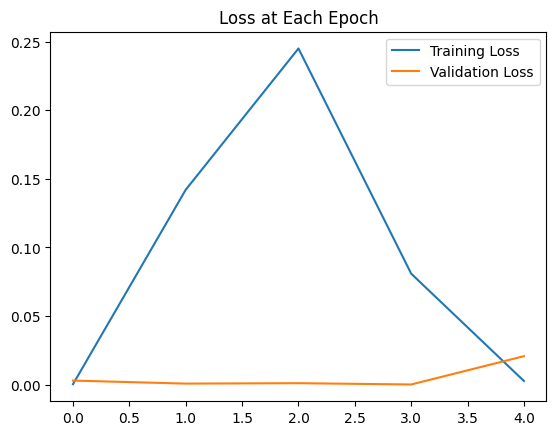

In [89]:
# graph the los at each epoch
train_losses = [tl.item() for tl in train_losses]
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.title('Loss at Each Epoch')
plt.legend()

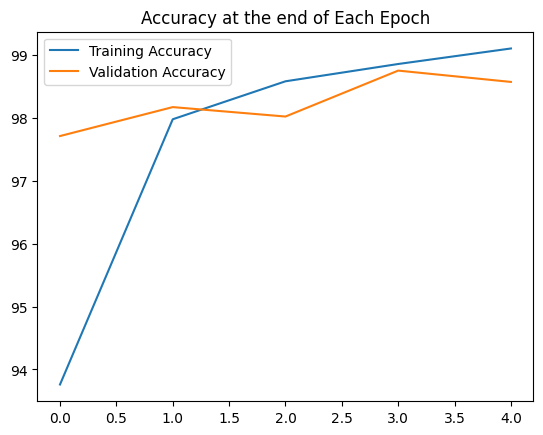

In [92]:
# graph teh accuracy at the end of each epoch
plt.plot([t/600 for t in train_correct], label='Training Accuracy')
plt.plot([t/100 for t in test_correct], label='Validation Accuracy')
plt.title('Accuracy at the end of Each Epoch')
plt.legend()

In [93]:
test_load_everything = DataLoader(test_data,batch_size=10000, shuffle = False)

In [96]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_everything:
    y_val = model(X_test)
    predicted = torch.max(y_val.data,1)[1]
    correct += (predicted == y_test).sum()

In [99]:
# test for correct
correct.item()/len(test_data)*100

98.57000000000001

In [100]:
# grab an image
test_data[4143] # tensor witht he image

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [101]:
# grab just the data
test_data[4143][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [102]:
# reshape
test_data[4143][0].reshape(28,28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

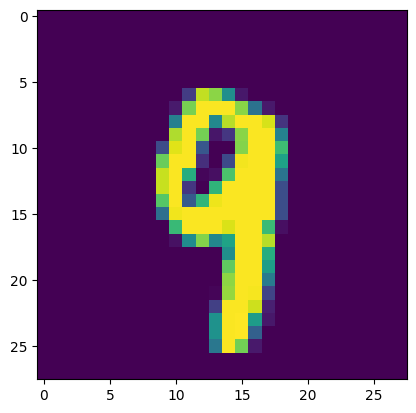

In [108]:
plt.imshow(test_data[4143][0].reshape(28,28))

In [109]:
# pass the image through the model
model.eval()
with torch.no_grad():
  new_prediction = model(test_data[4143][0].view(1,1,28,28)) # batch size of 1, 1 color channel, 28x28 image


In [110]:
# check the new prediction

new_prediction

tensor([[-2.1693e+01, -1.8584e+01, -2.1709e+01, -1.5842e+01, -8.6330e+00,
         -1.8415e+01, -3.1769e+01, -1.2734e+01, -1.3396e+01, -1.8273e-04]])

In [111]:
new_prediction.argmax()

tensor(9)